In [1]:
%pylab inline
import networkx as nx
import pandas as pd
import numpy as np
import json

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


{'treatmentSet': [7, 4, 6, 5],
 'controlSet': [0, 1, 2, 3],
 'treatment': [False, False, False, False, True, True, True, True]}

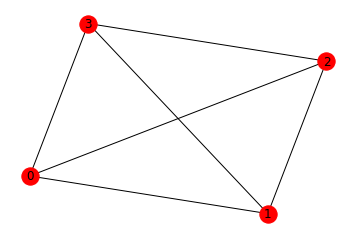

In [115]:
num_players = 8
control = True
n_neighbors = 3

if control:
    assert num_players % 2 == 0, "num_players must be even"
    num_treated = int(num_players / 2)
else:
    num_treated = num_players

game_data = dict()
players = [int(x) for x in range(num_players)]
game_data['treatmentSet'] = [int(i) for i in np.random.choice(players, num_treated, replace=False)]
game_data['controlSet'] = [int(i) for i in (set(players) - set(game_data["treatmentSet"]))]

game_data['treatment'] = [i in game_data['treatmentSet'] for i in range(num_players)]


g = nx.random_regular_graph(n_neighbors, num_treated)
nx.draw_networkx(g)
plt.box("off")
plt.xticks([])
plt.yticks([])

game_data

In [116]:
# assign neighbors
neighbors = {}
for n in range(num_treated):
    neighbors[game_data["treatmentSet"][n]] = [game_data["treatmentSet"][nb] for nb in g[n]]
    if control:
        neighbors[game_data["controlSet"][n]] = [game_data["controlSet"][nb] for nb in g[n]]
game_data['neighbors'] = neighbors
game_data

{'treatmentSet': [7, 4, 6, 5],
 'controlSet': [0, 1, 2, 3],
 'treatment': [False, False, False, False, True, True, True, True],
 'neighbors': {7: [4, 5, 6],
  0: [1, 3, 2],
  4: [6, 7, 5],
  1: [2, 0, 3],
  6: [4, 5, 7],
  2: [1, 3, 0],
  5: [4, 6, 7],
  3: [1, 2, 0]}}

In [117]:
# use_columns = ['Loc 1', 'Loc 2', 'Area 1', 'Area 2', 'Male 1', 'Male 2 ', 'Male 3',
#        'Female 1', 'Female 2', 'Female 3', 'Occupation 1', 'Occupation 2',
#        'Occupation 3', 'Crime 1', 'Crime 2', 'Event', 'Date 1', 'Date 2',
#        'Clothing 1', 'Clothing 2', 'Valuable Object 1', 'Valuable Object 2',
#        'Tool 1', 'Tool 2']

use_columns = ['Loc 1', 'Male 1',
       'Female 1', 'Occupation 1', 'Event', 'Date 1',
       'Clothing 1', 'Valuable Object 1',
       'Tool 1']

In [118]:
clue_nodes = pd.read_excel("Clues.xlsx", sheet_name="Nodes", )
clue_nodes['Date 1'] = clue_nodes['Date 1'].dt.strftime('%B %d')
clue_nodes['Date 2'] = clue_nodes['Date 2'].dt.strftime('%B %d')

clue_edges = pd.read_excel("Clues.xlsx", sheet_name="Edges")
clue_edges = clue_edges.loc[pd.notnull(clue_edges.index)] # drop null rows
clue_edges = clue_edges[use_columns].loc[use_columns]

In [119]:
# identify the nodes that will reresent concepts in the treatment group's belief network
treatment_nodes = {}
for col in clue_nodes.columns:
    treatment_nodes[col] = np.random.choice(list(clue_nodes[col].dropna()), 1)[0]
#treatment_nodes

In [120]:
# many nodes will be used in control group, shuffle their order
ctrl_nodes = {}
for col in clue_nodes.columns:
    ctrl_nodes[col] = list(np.random.permutation(list(clue_nodes[col].dropna())))
#control_nodes

In [121]:
clues = dict()
treatment_clue_ids = [] # facilitates assigning clues
for i, (row, series) in enumerate(clue_edges.iterrows()):
    for j, (col, val) in enumerate(series.iteritems()):
        if i < j:
            # treatment condition
            treat_row_node = str(treatment_nodes[row])
            treat_col_node = str(treatment_nodes[col])
            treat_clue_content = val.replace('{2}',treat_row_node).replace('{1}', treat_col_node).capitalize()+'.'
            treat_clue_id = "treat_clue_%i_%i"%(i+1,j+1)
            clues[treat_clue_id] = {"id": treat_clue_id,
                              "nodes":[i+1, j+1],
                              "content":[treat_clue_content]}
            treatment_clue_ids.append(treat_clue_id)
            
            # treatment condition
            ctrl_row_node = str(ctrl_nodes[row].pop())
            ctrl_col_node = str(ctrl_nodes[col].pop())
            ctrl_clue_content = val.replace('{2}',ctrl_row_node).replace('{1}', ctrl_col_node).capitalize()+'.'
            ctrl_clue_id = "ctrl_clue_%i_%i"%(i+1,j+1)
            clues[ctrl_clue_id] = {"id": ctrl_clue_id,
                              "nodes":[i+1, j+1],
                              "content":[ctrl_clue_content]}
            

game_data['clues'] = clues
print(len(clues))

72


In [124]:
clues

{'treat_clue_1_2': {'id': 'treat_clue_1_2',
  'nodes': [1, 2],
  'content': ['Brian was seen at the cinema.']},
 'ctrl_clue_1_2': {'id': 'ctrl_clue_1_2',
  'nodes': [1, 2],
  'content': ['Andrew was seen at the grocery store.']},
 'treat_clue_1_3': {'id': 'treat_clue_1_3',
  'nodes': [1, 3],
  'content': ['Susan was seen at the cinema.']},
 'ctrl_clue_1_3': {'id': 'ctrl_clue_1_3',
  'nodes': [1, 3],
  'content': ['Lisa was seen at the casino.']},
 'treat_clue_1_4': {'id': 'treat_clue_1_4',
  'nodes': [1, 4],
  'content': ['A janitor works near the cinema.']},
 'ctrl_clue_1_4': {'id': 'ctrl_clue_1_4',
  'nodes': [1, 4],
  'content': ['A teacher works near the church.']},
 'treat_clue_1_5': {'id': 'treat_clue_1_5',
  'nodes': [1, 5],
  'content': ['The award ceremony happened at the cinema.']},
 'ctrl_clue_1_5': {'id': 'ctrl_clue_1_5',
  'nodes': [1, 5],
  'content': ['The lecture happened at the gym.']},
 'treat_clue_1_6': {'id': 'treat_clue_1_6',
  'nodes': [1, 6],
  'content': ['The c

In [128]:
print('\n'.join([cl['content'][0] for cl in clues.values()][0::2]))

Brian was seen at the cinema.
Susan was seen at the cinema.
A janitor works near the cinema.
The award ceremony happened at the cinema.
The cinema was busy on may 12.
A pair of work boots was found in the cinema.
The evidence was at the cinema.
A crowbar was found in the cinema.
Susan is friends with brian.
Brian works as a janitor.
Brian attended the award ceremony.
Brian did not go to work on may 12.
Brian owns a a pair of work boots.
Brian had been to see the evidence.
Brian had recently purchased a crowbar.
Susan works as a janitor.
Susan attended the award ceremony.
Susan did not go to work on may 12.
Susan owns a a pair of work boots.
Susan had been to see the evidence.
Susan had recently purchased a crowbar.
A janitor attended the award ceremony.
A janitor did not go to work on may 12.
A janitor was seen wearing a pair of work boots.
A janitor had been to see the evidence.
A janitor has access to a crowbar.
The award ceremony happened on may 12.
A pair of work boots was at the a

In [99]:
beliefs = {}
for n in range(num_treated):
    treat_beliefs = list(np.random.choice(treatment_clue_ids, 5, replace=False))
    beliefs[game_data["treatmentSet"][n]] = treat_beliefs

    if control:
        control_beliefs = [bf.replace('treat', 'ctrl') for bf in treat_beliefs]
        beliefs[game_data["controlSet"][n]] = control_beliefs        


    
game_data['beliefs'] = beliefs

In [80]:
game_data

{'treatmentSet': [0, 1, 2, 3],
 'controlSet': [],
 'treatment': [True, True, True, True],
 'clues': {'treat_clue_1_2': {'id': 'treat_clue_1_2',
   'nodes': [1, 2],
   'content': ['John was seen at the gym.']},
  'ctrl_clue_1_2': {'id': 'ctrl_clue_1_2',
   'nodes': [1, 2],
   'content': ['Brian was seen at the office.']},
  'treat_clue_1_3': {'id': 'treat_clue_1_3',
   'nodes': [1, 3],
   'content': ['Sandra was seen at the gym.']},
  'ctrl_clue_1_3': {'id': 'ctrl_clue_1_3',
   'nodes': [1, 3],
   'content': ['Lisa was seen at the library.']},
  'treat_clue_1_4': {'id': 'treat_clue_1_4',
   'nodes': [1, 4],
   'content': ['A clockmaker works near the gym.']},
  'ctrl_clue_1_4': {'id': 'ctrl_clue_1_4',
   'nodes': [1, 4],
   'content': ['A chef works near gas station.']},
  'treat_clue_1_5': {'id': 'treat_clue_1_5',
   'nodes': [1, 5],
   'content': ['The convention happened at the gym.']},
  'ctrl_clue_1_5': {'id': 'ctrl_clue_1_5',
   'nodes': [1, 5],
   'content': ['The food festival h

In [100]:
with open("game_data_8_player_no_control.json", 'w') as f:
    f.write(json.dumps(game_data, indent=1))